## abs

In [20]:
# import packages
import pandas as pd
import random
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from pickle import load
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.merge import concatenate
from keras import backend as K
import keras
import keras_metrics
import tensorflow as tf    
from tensorflow import keras 
import keras_metrics as km

from tensorflow.python.ops import math_ops

import csv
import pydot
from pickle import dump

In [21]:
# load the package
final_df = pd.read_csv('/project/train_data.csv')

In [22]:
final_df.head()

,Unnamed: 0,abstract.text_sw,biblio.invention_title.text_sw,claims.claims_sw,yo2
0,98980,disclosure relates hand control input device c...,unknown,a hand control input device comprising a ...,0
1,69824,one aspect present invention directed plant pl...,bacterial spore compositions for industrial uses,a plant or plant part coated with a composi...,1
2,9928,demonstrative embodiments include apparatuses ...,apparatus system and method of setting up an ...,a product comprising one or more tangible c...,0
3,75599,wavelength multiplexing apparatus includes div...,wavelength multiplexing apparatus and method,a wavelength multiplexing apparatus compris...,0
4,95621,first second inputs received first input indic...,method and apparatus for transmitter optimizat...,canceled a system comprising one ...,0


In [23]:
final_df.shape

(75000, 5)

In [24]:
# split X and y
y = final_df['yo2']
X = final_df.drop(columns = 'yo2')
X['tac'] = X['biblio.invention_title.text_sw'] + ' ' + X['abstract.text_sw'] + ' ' + X['claims.claims_sw']
X['title_abs'] = X['biblio.invention_title.text_sw'] + ' ' + X['abstract.text_sw'] 
X['title_claims'] = X['biblio.invention_title.text_sw'] + ' ' + X['claims.claims_sw']
X['abs_claims'] = X['abstract.text_sw'] + ' ' + X['claims.claims_sw']
X['abstract'] = X['abstract.text_sw']
X['title'] = X['biblio.invention_title.text_sw']
X['claims'] = X['claims.claims_sw']

In [25]:
# split train and test
trainX, testX, trainy, testy = train_test_split(X['abstract'], y, test_size=0.25, random_state = 42)

In [26]:
# the testX and testy here is the validation data and not the actual testing data

In [27]:
trainX.shape,trainy.shape,testX.shape,testy.shape

((56250,), (56250,), (18750,), (18750,))

In [28]:
def save_dataset(dataset, filename):
    dump(dataset, open(filename, 'wb'))
    print('Saved: %s' % filename)
    
save_dataset([trainX,trainy], 'train_abs.pkl') 

Saved: train_abs.pkl


In [29]:
filename = 'train_abs.pkl'

In [30]:
import tensorflow_addons as tfa

In [31]:
# load a clean dataset
def load_dataset(filename):
    return load(open(filename, 'rb'))

# fit a tokenizer
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

# calculate the maximum document length
def max_length(lines):
    return max([len(s.split()) for s in lines])

# encode a list of lines
def encode_text(tokenizer, lines, length):
    # integer encode
    encoded = tokenizer.texts_to_sequences(lines)
    # pad encoded sequences
    padded = pad_sequences(encoded, maxlen=length, padding='post')
    return padded

# define the model
def define_model(length, vocab_size):
    # channel 1
    inputs1 = Input(shape=(length,))
    embedding1 = Embedding(vocab_size, 100)(inputs1)
    conv1 = Conv1D(filters=32, kernel_size=2, activation='relu')(embedding1)
    drop1 = Dropout(0.5)(conv1)
    pool1 = MaxPooling1D(pool_size=2)(drop1)
    flat1 = Flatten()(pool1)
    
    # channel 2
    inputs2 = Input(shape=(length,))
    embedding2 = Embedding(vocab_size, 100)(inputs2)
    conv2 = Conv1D(filters=32, kernel_size=3, activation='relu')(embedding2)
    drop2 = Dropout(0.5)(conv2)
    pool2 = MaxPooling1D(pool_size=2)(drop2)
    flat2 = Flatten()(pool2)
    
    # channel 3
    inputs3 = Input(shape=(length,))
    embedding3 = Embedding(vocab_size, 100)(inputs3)
    conv3 = Conv1D(filters=32, kernel_size=4, activation='relu')(embedding3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling1D(pool_size=2)(drop3)
    flat3 = Flatten()(pool3)
    
    # merge
    merged = concatenate([flat1, flat2, flat3])
    # interpretation
    dense1 = Dense(500, activation='relu')(merged)
    outputs = Dense(1, activation='sigmoid')(dense1)
    model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
    # compile
    model.compile(loss='binary_crossentropy', optimizer='adam', 
                  metrics=[tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),tf.keras.metrics.AUC(curve='ROC')]) #Reports the AUC of a model outputing a probability.
#                            tf.math.confusion_matrix(y_test, y_pred, num_classes=None, weights=None, dtype=tf.dtypes.int32,name=None)])
                                                                        
    # summarize
    print(model.summary())
    plot_model(model, show_shapes=True, to_file='multichannel_abs.png')
    return model

In [38]:
# load training dataset
trainLines, trainLabels = load_dataset(filename)

# create tokenizer
tokenizer = create_tokenizer(trainLines)

# calculate max document length
length = max_length(trainLines)

# calculate vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print('Max document length: %d' % length)
print('Vocabulary size: %d' % vocab_size)

# encode data
trains_X = encode_text(tokenizer, trainLines, length)
print(trains_X.shape)

# define model
model = define_model(length, vocab_size)

class_weights = 1/(trainLabels.value_counts()/len(trainLabels))
class_weights = {0: class_weights[0], 1: class_weights[1]}

# fit model
history = model.fit([trains_X,trains_X,trains_X], array(trainLabels), epochs=9, batch_size=16, class_weight=class_weights)

# save the model
model.save('model_abs.h5')

Max document length: 511
Vocabulary size: 43473
(56250, 511)
Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           [(None, 511)]        0                                            
__________________________________________________________________________________________________
input_23 (InputLayer)           [(None, 511)]        0                                            
__________________________________________________________________________________________________
input_24 (InputLayer)           [(None, 511)]        0                                            
__________________________________________________________________________________________________
embedding_21 (Embedding)        (None, 511, 100)     4347300     input_22[0][0]                   
_______________________________

dict_keys(['loss', 'precision_5', 'recall_5', 'auc_5'])


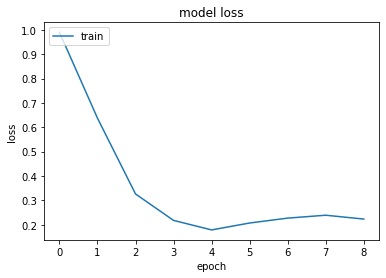

In [36]:
import matplotlib.pyplot as plt

#list all data in history
print(history.history.keys())

# summarize history forhistory_absloss
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()